In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cv2
import torch
import torch.functional as F
import torch.nn as nn
from torch.optim import Adam
from time import time, sleep

from utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader
from autoencoders import *

#### Example bug rotation

[source](https://docs.opencv.org/master/dd/d43/tutorial_py_video_display.html)

In [33]:
import numpy as np
import cv2 as cv
cap = cv.VideoCapture('data/experience/R25.mp4')
# Define the codec and create VideoWriter object
fourcc = cv.VideoWriter_fourcc(*'MP4V')
out = cv.VideoWriter('data/rotation_bug.mp4', fourcc, 24.0, (1920, 1080))
i = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
        
    # stop at ~6s
    if i > 150:
        break
    i += 1
    out.write(frame)
# Release everything if job is finished
cap.release()
out.release()

#### Transform video

In [13]:
video = VideoLoader('data/experience/R25/R25.mp4', gray=True, scale=(256, 256))
video.write('data/experience/R25/R25_gray_scaled.mp4')

#### params

In [3]:
ncomp = 50
skip_frame = 3
num_epoch = 30
video = VideoLoader('data/experience/R25/R25_gray_scaled.mp4', gray=True, randit=True, skip_frame=skip_frame)

### PCA

In [5]:
model1 = custom_pca(ncomp)
video.batch_size = np.inf
video.torch = False

t1 = time()
for frames_fit in video:
    model1.fit(frames_fit)
t2 = time()

In [9]:
video.randit = video.skip_frame = 0
video.batch_size = 64
t3 = time()
reconstructed = video.reduce_latent(model1, trans=True)
t4 = time()

In [10]:
exact_loss = reconstruction_error(reconstructed,
                                  video.get_all_frames())
      
print('Fitting time:', sec2string(t2-t1))
print('Transform time:', sec2string(t4-t3))
print('Reconstruction error:', exact_loss)

Reconstruction error: 3.877609350923941


In [12]:
write_video('data/experience/R25/R25_pca_50.mp4', reconstructed, video.width, video.height, video.fps, True)

### PCA AE

In [14]:
video.torch = True
video.batch_size = 64
video.randit = True
video.skip_frame = skip_frame

model2 = PCAAutoEncoder((video.width, video.height), ncomp)

for lr in [1e-4]:
    for wd in [0.1]:
        optimizer = Adam(model2.parameters(), lr=lr, weight_decay=wd)
        print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in model2.parameters()])}')
        
        losses = []
        for i in range(20):
            t1 = time()
            epoch_loss = 0
            nframe = 0
            for x in video:
                nframe += x.shape[0]
                x_reconstructed = model2(x)
                batch_loss = crit(x_reconstructed, x)
                epoch_loss += batch_loss.item()

                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

            nbatch = np.ceil(video.duration_frames / (video.batch_size * (video.skip_frame+1)))
            losses.append(epoch_loss / nbatch)
            print('Loss at %d:' % i, losses[-1], f'(took {round(time()-t1, 1)}s, {nframe} frames)')


ncomp -> 50, lr -> 0.0001, wd -> 0.1, nparams -> 6619186
Loss at 0: 305.58094278971356 (took 43.0s, 358 frames)
Loss at 1: 210.41419219970703 (took 41.3s, 358 frames)
Loss at 2: 188.30128733317056 (took 41.3s, 358 frames)
Loss at 3: 170.5029525756836 (took 42.4s, 358 frames)
Loss at 4: 164.16704813639322 (took 44.7s, 358 frames)
Loss at 5: 159.26025899251303 (took 43.6s, 358 frames)
Loss at 6: 156.51292673746744 (took 44.1s, 358 frames)
Loss at 7: 155.12157694498697 (took 44.2s, 358 frames)
Loss at 8: 154.55227661132812 (took 42.9s, 358 frames)
Loss at 9: 154.3581568400065 (took 42.6s, 358 frames)
Loss at 10: 154.08846028645834 (took 42.6s, 358 frames)
Loss at 11: 154.00265757242838 (took 41.6s, 358 frames)
Loss at 12: 153.36788940429688 (took 42.0s, 358 frames)
Loss at 13: 153.44606272379556 (took 42.3s, 358 frames)
Loss at 14: 154.51869201660156 (took 41.6s, 358 frames)
Loss at 15: 153.67655436197916 (took 42.8s, 358 frames)
Loss at 16: 154.3872273763021 (took 46.2s, 358 frames)
Loss

In [24]:
video.randit = video.skip_frame = 0

print('Fitting time:', sec2string(865.4))

t3 = time()
exact_loss = reconstruction_error(video.reduce_latent(model2, trans=False).numpy(), video.get_all_frames().squeeze().numpy())
t4 = time()
print('Transform time:', sec2string(t4-t3))

print('Reconstruction error:', exact_loss)

Fitting time: 14:25
Transform time: 4.75
Reconstruction error: 154.03314


### Establishing baseline w.r.t PCA

ncomp -> 50, lr -> 0.001, wd -> 0.05, nparams -> 6619186
Time taken for fitting with 30 epochs: 0:04:43.255647
Time taken to transform: 23.56
Reconstruction error: 17.841055


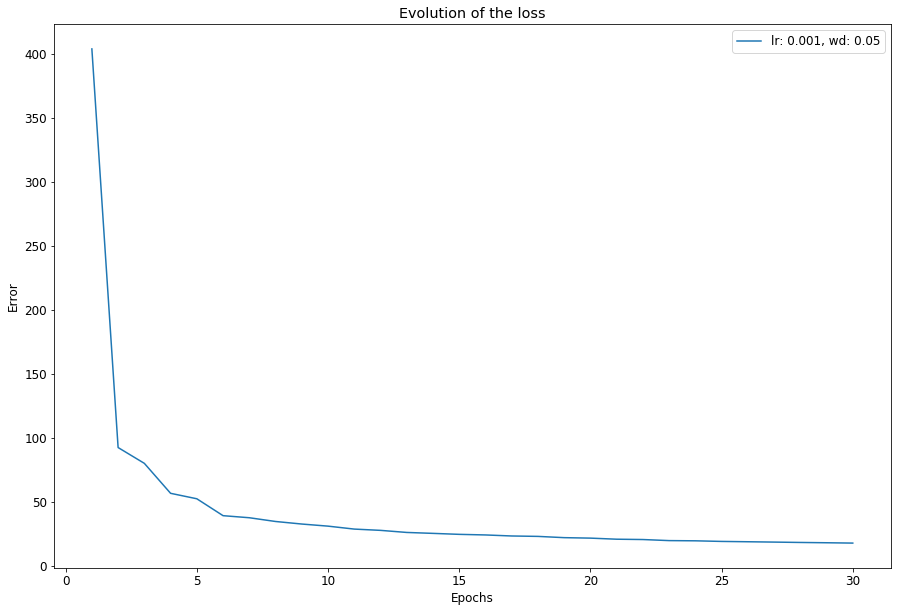

In [15]:
ncomp = 50
video = VideoLoader('data/big_sample_256.mp4', duration=5*60, randit=True, skip_frame=3, grayscale=True)
net = PCAAutoEncoder((video.width, video.height), ncomp)
lr, wd, num_epoch = 0.001, 0.05, 30 # Tuned hyper-parameters
optimizer = Adam(net.parameters(), lr=lr, weight_decay=wd)
print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in net.parameters()])}')


start = time()
losses = []
for i in range(num_epoch):
    epoch_loss = 0
    num_batch  = 0
    for x in video:
        num_batch += 1
        x = torch.from_numpy(x).float()
        x_reconstructed = net(x)
        batch_loss = crit(x_reconstructed, x)
        epoch_loss += batch_loss.item()
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    losses.append(epoch_loss / num_batch)
fitting_time = sec2string(time() - start)

video.randit = video.skip_frame = 0
start = time()

reconstructed = []
for x in video:
    x = torch.from_numpy(x).float()
    reconstructed.append(net(x).detach().numpy())
reconstructed = np.vstack(reconstructed)
transform_time = sec2string(time() - start)

exact_loss = reconstruction_error(reconstructed,
                                  video.get_all_frames())
      
print(f'Time taken for fitting with {num_epoch} epochs:', fitting_time)
print('Time taken to transform:', transform_time)

print('Reconstruction error:', exact_loss)
losses = np.array(losses)
plot(range(1, num_epoch+1), [losses], title='Evolution of the loss', xlabel='Epochs', ylabel='Error', labels=['lr: 0.001, wd: 0.05'])

As a comparison for PCA:
Error of 7.45 after 36s of fitting time

In [16]:
write_video('data/big_sample_pcaae_50.mp4', reconstructed, video.width, video.height, video.fps, grayscale=True)

## Adding layers

### One-hidden

ncomp -> 50, lr -> 0.0005, wd -> 0.01, nparams -> 26300386
Time taken for fitting with 30 epochs: 8:52
Time taken to transform: 28.68
Reconstruction error: 14.618819236755371


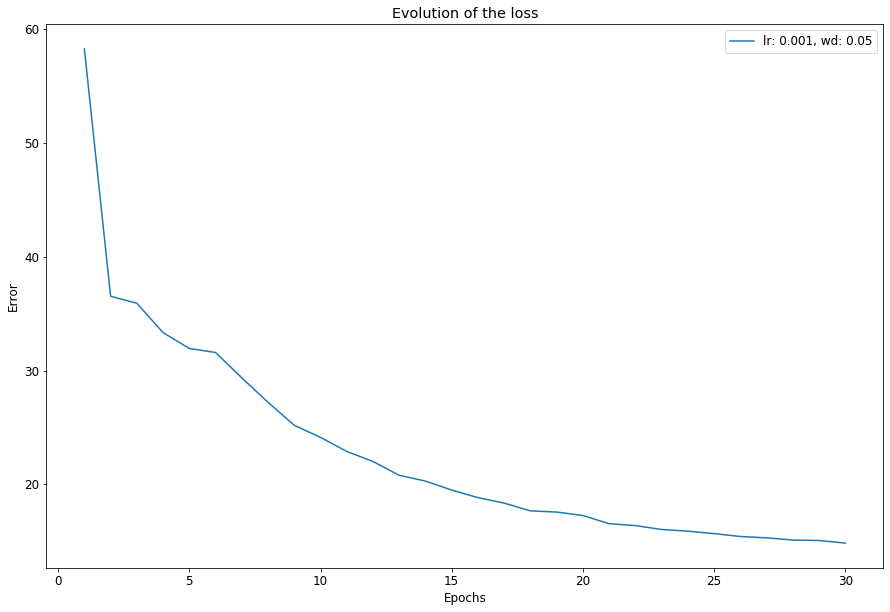

In [3]:
ncomp = 50
video = VideoLoader('data/big_sample_256.mp4', duration=5*60, randit=True, skip_frame=3, gray=True)
net = OneAutoEncoder((video.width, video.height), ncomp)
lr, wd, num_epoch = 0.0005, 0.01, 30
optimizer = Adam(net.parameters(), lr=lr, weight_decay=wd)
print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in net.parameters()])}')

start = time()
losses = []
for i in range(num_epoch):
    epoch_loss = 0
    num_batch  = 0
    for x in video:
        num_batch += 1
        x_reconstructed = net(x)
        batch_loss = crit(x_reconstructed, x)
        epoch_loss += batch_loss.item()
    
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    losses.append(epoch_loss / num_batch)
fitting_time = sec2string(time() - start)
start = time()
reconstructed = video.reduce_latent(net)
transform_time = sec2string(time() - start)

exact_loss = crit(reconstructed, video.get_all_frames()).item()
      
print(f'Time taken for fitting with {num_epoch} epochs:', fitting_time)
print('Time taken to transform:', transform_time)

print('Reconstruction error:', exact_loss)
losses = np.array(losses)
plot(range(1, num_epoch+1), [losses], title='Evolution of the loss', xlabel='Epochs', ylabel='Error', labels=['lr: 0.001, wd: 0.05'])

### Trying convolutions

ncomp -> 50, lr -> 0.0005, wd -> 0.0005, nparams -> 5142131
Time taken for fitting with 30 epochs: 1:15:04
Time taken to transform: 3:36
Reconstruction error:


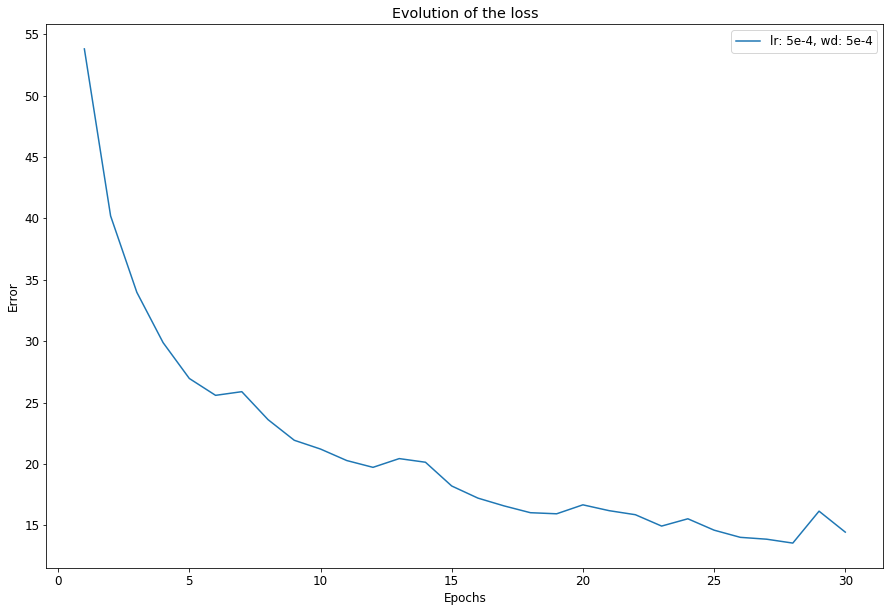

In [13]:
ncomp = 50
video = VideoLoader('data/big_sample_256.mp4', duration=5*60, randit=True, skip_frame=3, gray=True)

num_epoch = 1
for lr in [5e-4]:
    for wd in [5e-4]:
        net = SpatialConvAE(1, ncomp)
        optimizer = Adam(net.parameters(), lr=lr, weight_decay=wd)
        print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in net.parameters()])}')
    
        start = time()
        losses = []
        for i in range(num_epoch):
            epoch_loss = 0
            num_batch  = 0
            for x in video:
                num_batch += 1
                x_reconstructed = net(x)
                batch_loss = crit(x_reconstructed, x)
                epoch_loss += batch_loss.item()
            
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()
            losses.append(epoch_loss / num_batch)
            
fitting_time = sec2string(time() - start)
start = time()
reconstructed = video.reduce_latent(net)
transform_time = sec2string(time() - start)

print(transform_time)

#exact_loss = crit(reconstructed, video.get_all_frames()).item()
print('ncomp -> 50, lr -> 0.0005, wd -> 0.0005, nparams -> 5142131')
print(f'Time taken for fitting with {num_epoch} epochs:', fitting_time)
print('Time taken to transform:', transform_time)

print('Reconstruction error:')#, exact_loss)
plot(range(1, num_epoch+1), [losses], title='Evolution of the loss', xlabel='Epochs', ylabel='Error', labels=['lr: 5e-4, wd: 5e-4'])

Note: the exact loss is false, kernel died during computation

# TRASH

In [26]:
import cv2
import numpy as np
# Create a VideoCapture object
cap = cv2.VideoCapture('data/experience/R25.mp4')

# Check if camera opened successfully
if (cap.isOpened() == False): 
    print("Unable to read camera feed")
# Default resolutions of the frame are obtained.The default resolutions are system dependent.
# We convert the resolutions from float to integer.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
out = cv2.VideoWriter('outpy.mp4',cv2.VideoWriter_fourcc(*"MP4V"), 24, (frame_height//2,frame_width//2), 0)
while(True):
    ret, frame = cap.read()
    if ret == True: 
        frame = np.transpose(frame, axes=[1,0, 2])
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Write the frame into the file 'output.avi'
        frame = cv2.resize(frame, (frame_height//2, frame_width//2), interpolation=cv2.INTER_AREA)
        out.write(frame)
    # Display the resulting frame
    # Press Q on keyboard to stop recording
  # Break the loop
    else:
        break 
# When everything done, release the video capture and video write objects
cap.release()
out.release()

In [17]:
cv2.destroyAllWindows()